In [ ]:
!pip install -q tensorflow==2.1

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

print(tf.__version__)

2.1.0


In [ ]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-ec0a1d0a-9b73-a166-2214-86dc09342e4f)


## Load and preprocess MNIST dataset

In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)

(60000, 28, 28, 1) float32
(10000, 28, 28, 1) float32


## Draw MNIST examples

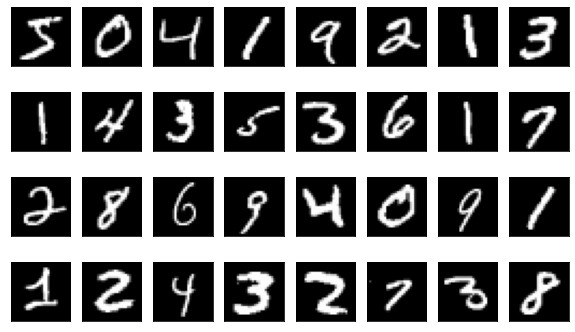

In [ ]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 6))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

## Create Autoencoder model: Encoder and Decoder

In [ ]:
train_x.shape[1:]

(28, 28, 1)

In [ ]:
encoder = M.Sequential([
    #L.ZeroPadding2D((2, 2)),
    L.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=train_x.shape[1:]),
    L.MaxPooling2D((2, 2), padding='same'),
    L.Conv2D(8, (3, 3), padding='same', activation='relu'),
    L.MaxPooling2D((2, 2), padding='same'),
    L.Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'),
    # Flatten encoding for visualization
    L.Flatten(),
    L.Reshape((4, 4, 8)),
])

decoder = M.Sequential([
    L.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(4, 4, 8)),
    L.UpSampling2D((2, 2)),
    L.Conv2D(8, (3, 3), padding='same', activation='relu'),
    L.UpSampling2D((2, 2)),
    L.Conv2D(8, (3, 3), padding='same', activation='relu'),
    L.UpSampling2D((2, 2)),
    L.Conv2D(1, (3, 3), padding='same', activation='sigmoid'),
    L.Cropping2D((2, 2))
])

autoencoder = M.Sequential([encoder, decoder])

autoencoder.compile(optimizer='RMSprop', loss='mse')

In [ ]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 4, 4, 8)           1904      
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         1825      
Total params: 3,729
Trainable params: 3,729
Non-trainable params: 0
_________________________________________________________________


## Autoencoder training

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

In [ ]:
autoencoder.fit(train_x, train_x,
                epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(test_x, test_x))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0483 - val_loss: 0.0331
Epoch 2/25
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0292 - val_loss: 0.0251
Epoch 3/25
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0237 - val_loss: 0.0217
Epoch 4/25
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0204 - val_loss: 0.0191
Epoch 5/25
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0184 - val_loss: 0.0162
Epoch 6/25
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0170 - val_loss: 0.0195
Epoch 7/25
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0159 - val_loss: 0.0146
Epoch 8/25
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0150 - val_loss: 0.0142
Epoch 9/25
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0143 - val_

## Autoencoder inference test

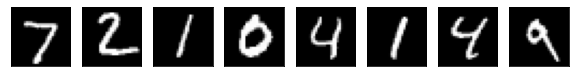

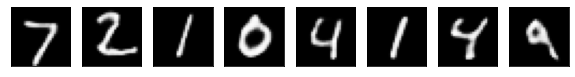

In [ ]:
text_x_pred = autoencoder.predict(test_x[0:8])

plot_digits(test_x[0:8])
plot_digits(text_x_pred)

Посмотрим как происходит транформация по этапам

In [ ]:
num_images = 10
random_test_images = np.random.randint(test_x.shape[0], size=num_images)

encoded_imgs = encoder.predict(test_x)
decoded_imgs = decoder.predict(encoded_imgs)

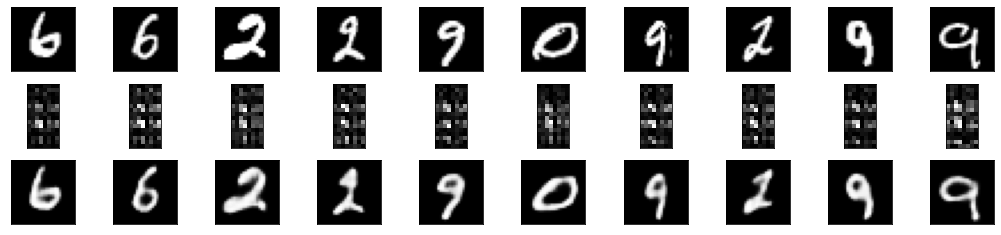

In [ ]:
plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(test_x[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Decoder inference test: random inputs

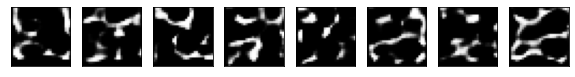

In [ ]:
plot_digits(decoder.predict(np.random.rand(8, 4, 4, 8) * 5))

## Prepare noisy dataset (for Denoising AE)

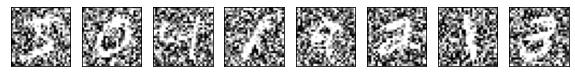

In [ ]:
def add_noise(x):
    return np.clip(x + 0.5 + 0.5*np.random.randn(*x.shape), 0, 1)

train_x_noise = add_noise(train_x)
test_x_noise = add_noise(test_x)

plot_digits(train_x_noise[:8])

## Denoising Autoencoder training

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 128

autoencoder.fit(train_x_noise, train_x,
                epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(test_x_noise, test_x))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0329 - val_loss: 0.0329
Epoch 2/25
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0272 - val_loss: 0.0247
Epoch 3/25
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0254 - val_loss: 0.0248
Epoch 4/25
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0242 - val_loss: 0.0240
Epoch 5/25
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0233 - val_loss: 0.0225
Epoch 6/25
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0226 - val_loss: 0.0217
Epoch 7/25
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0220 - val_loss: 0.0216
Epoch 8/25
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0216 - val_loss: 0.0218
Epoch 9/25
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0213 - val_

## Denoising Autoencoder inference test

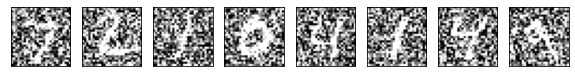

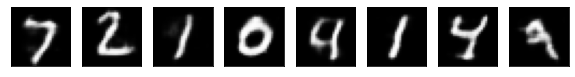

In [ ]:
text_x_pred = autoencoder.predict(test_x_noise[0:8])

plot_digits(test_x_noise[0:8])
plot_digits(text_x_pred)